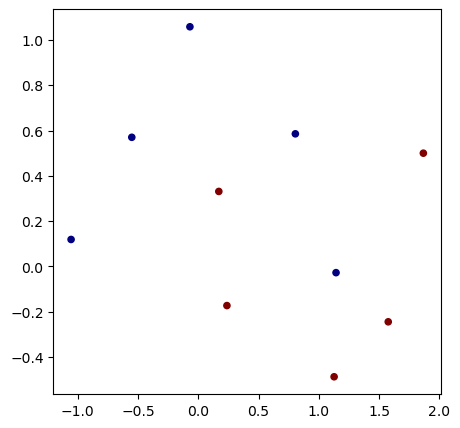

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
from shrimpgrad import Tensor, nn, dtypes
import random

np.random.seed(1337)
random.seed(1337)
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=10, noise=0.1)
X = X.astype(float)
y = y.astype(float)
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')


In [2]:
X_train = Tensor.fromlist(X.shape, X.flatten().tolist())
y_train = Tensor.fromlist(y.shape, y.flatten().tolist())
print(y_train)
class Model:
    def __init__(self):
        self.layers: List[Callable[[Tensor], Tensor]] = [
         nn.Linear(2, 6), Tensor.relu,
         nn.Linear(6, 1), Tensor.relu, 
        ]
    def __call__(self, x: Tensor):
        return x.sequential(self.layers)

tensor([1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0])


In [3]:
def get_parameters(model):
    params = []
    for layer in model.layers:
        if getattr(layer, 'parameters', None):
            params+=layer.parameters()
    return params

def optimize(model, x_train, target, epochs=1000, lr=0.01):
    epsilon = 1e-10
    for epoch in range(epochs):
        out = model(x_train)
        numerator = ((target > 0) == (out.reshape(10) > 0)).sum().cast(dtypes.float32)

        accuracy = (numerator / out.size(0)) * 100.0
        loss = out.binary_cross_entropy(target.clamp(epsilon, 1-epsilon))
        params = get_parameters(model)
        for p in params: p.grad = None
        loss.backward()
        print(f'epoch={epoch} loss={loss} acc={accuracy}')
        for param in params:
            param.data = (param + (-param.grad) * lr).data
    return model
optimize(Model(), X_train, y_train, epochs=1, lr=0.1)

tensor([[0.2982172341746257],
 [0.31597165631679275],
 [0.3391928236307137],
 [0.30232132505988213],
 [0.31162684646196004],
 [0.3305540997923141],
 [0.3287145262126919],
 [0.38451869347014606],
 [0.36977554855792116],
 [0.33948371407448186]])
tensor([[-1.2099330843086793],
 [-1.1521027646181028],
 [-1.0811865320372713],
 [-1.196264836979213],
 [-1.165948811886944],
 [-1.1069849423379619],
 [-1.1125656063687825],
 [-0.9557628736105739],
 [-0.9948590829347046],
 [-1.0803293034595312]])
tensor([[-1.209933084187686,
  -1.2099330843086792e-10,
  -1.2099330843086792e-10,
  -1.2099330843086792e-10,
  -1.209933084187686,
  -1.2099330843086792e-10,
  -1.2099330843086792e-10,
  -1.209933084187686,
  -1.209933084187686,
  -1.209933084187686],
 [-1.1521027645028925,
  -1.1521027646181028e-10,
  -1.1521027646181028e-10,
  -1.1521027646181028e-10,
  -1.1521027645028925,
  -1.1521027646181028e-10,
  -1.1521027646181028e-10,
  -1.1521027645028925,
  -1.1521027645028925,
  -1.1521027645028925],
 [-1.0

In [4]:
import torch

class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(2, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

loss_fn = torch.nn.BCELoss()
model = NeuralNetwork()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

def optimize_torch(model, X, y, optimizer, epochs=100):
    for epoch in range(epochs):
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(X)
        # Compute the loss and its gradients
        loss = loss_fn(outputs, y)
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        print(f'epoch={epoch} loss={loss}')
optimize_torch(model, torch.tensor(X, dtype=torch.float32), torch.tensor(y.reshape(100,1), dtype=torch.float32), optimizer)

ValueError: cannot reshape array of size 10 into shape (100,1)

In [ ]:
x = torch.ones(100,1)
y = torch.ones(100)

z = x == y

z.shape

torch.tensor(-1).log()